# Quantization

In [2]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu'
os.environ['JAX_ENABLE_X64'] = 'True'
import jax
import jax.numpy as jnp
import numpy as np
import jax.extend
import matplotlib.pyplot as plt

The naive recipe for quantized inference is simple:

```python
jnp.dot(X, W) \approx (jnp.dot(X.astype(new_dtype), W.astype(new_dtype))).astype(old_dtype)
```

In [36]:
{k: jnp.issubdtype(k, jnp.integer) for k in jax.extend.core.array_types}

{numpy.uint64: True,
 ml_dtypes.float8_e3m4: False,
 numpy.int64: True,
 ml_dtypes.bfloat16: False,
 numpy.complex128: False,
 numpy.float16: False,
 numpy.ndarray: False,
 numpy.uint8: True,
 numpy.int8: True,
 ml_dtypes.float8_e4m3b11fnuz: False,
 ml_dtypes.uint4: True,
 ml_dtypes.int2: True,
 numpy.float64: False,
 numpy.uint32: True,
 numpy.int32: True,
 ml_dtypes.float8_e5m2fnuz: False,
 numpy.complex64: False,
 ml_dtypes.float8_e4m3: False,
 ml_dtypes.int4: True,
 numpy.longlong: True,
 numpy.bool_: False,
 ml_dtypes.float8_e8m0fnu: False,
 ml_dtypes.float8_e4m3fnuz: False,
 numpy.float32: False,
 numpy.uint16: True,
 ml_dtypes.float8_e4m3fn: False,
 numpy.int16: True,
 ml_dtypes.float8_e5m2: False,
 ml_dtypes.uint2: True}

In [ ]:
jax.extend.core.array_types

Quantized to object error: JAX only supports number, bool, and string dtypes, got dtype <class 'numpy.ndarray'> in astype
Quantized to int2 error: UNIMPLEMENTED: unsupported operand type S2 in op dot
Quantized to float8_e8m0fnu error: 
Quantized to uint2 error: UNIMPLEMENTED: unsupported operand type U2 in op dot


/tmp/ipykernel_1260832/461205743.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1260832/461205743.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha='right');


(0.9, 1.0)

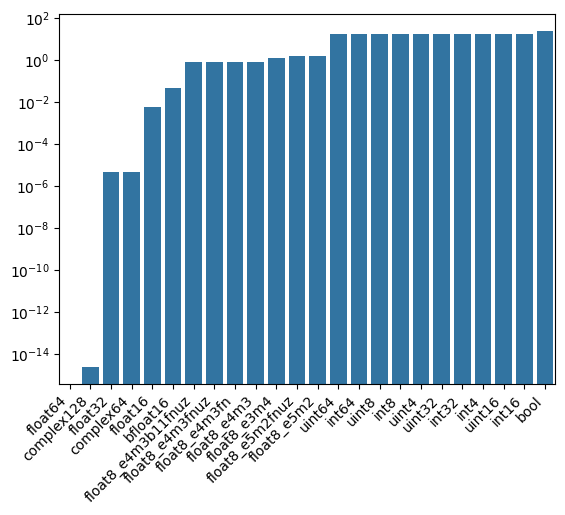

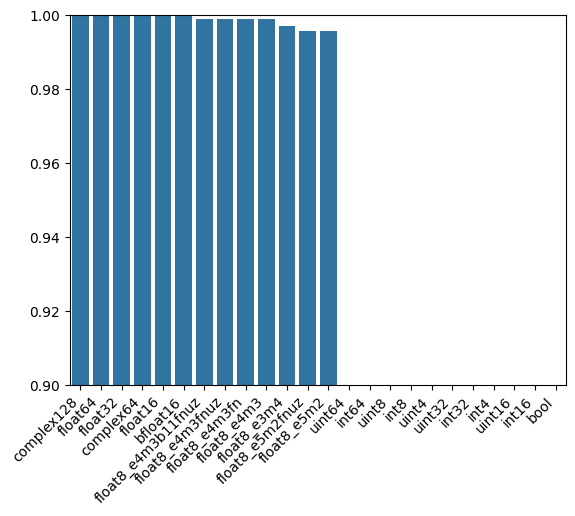

In [98]:
def quantized_dot(X, W, quantized_dtype):
    old_dtype = X.dtype
    X_q = X.astype(quantized_dtype)
    W_q = W.astype(quantized_dtype)
    # We want to do accumulation in int32 if the dtype is integer (to avoid overflow)
    preferred_element_type = jnp.int32 if jnp.promote_types(quantized_dtype, jnp.int32) ==  jnp.int32 else None
    output = jnp.dot(X_q, W_q, preferred_element_type=preferred_element_type)
    return output.astype(old_dtype)

rng = np.random.default_rng(0)

X = jnp.asarray(rng.normal(size=(1000, 256))).astype(jnp.float64)
w = jnp.asarray(rng.normal(size=(256, 256)) / np.sqrt(256)).astype(jnp.float64) # He initialization


gt = X @ w

def cossim(a, b, axis=-1):
    ab = (a * b).sum(axis=axis)
    a_norm = jnp.linalg.norm(a, axis=axis)
    b_norm = jnp.linalg.norm(b, axis=axis)
    return ab / jnp.clip(a_norm * b_norm, a_min=1e-10)

errors = {}
cossims = {}
for quantized_dtype in jax.extend.core.array_types:
    try:
        pred = naive_quantized_dot(X, w, quantized_dtype)
        error = jnp.linalg.norm(pred - gt, axis=-1).mean()
        cossim_ = cossim(pred, gt, axis=-1).mean()
        assert not jnp.isnan(error)
        errors[jnp.dtype(quantized_dtype).name] = error.item()
        cossims[jnp.dtype(quantized_dtype).name] = cossim_.item()
    except Exception as e:
        print(f"Quantized to {jnp.dtype(quantized_dtype)} error: {e}")


import seaborn as sns
sorted_errors = sorted(errors.items(), key=lambda x: x[1])
plot = sns.barplot(x=[x[0] for x in sorted_errors], y=[x[1] for x in sorted_errors])
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha='right')
plot.set_yscale('log')

plt.figure()
sorted_cossims = sorted(cossims.items(), key=lambda x: x[1], reverse=True)
plot = sns.barplot(x=[x[0] for x in sorted_cossims], y=[x[1] for x in sorted_cossims])
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha='right');
plt.ylim(0.9, 1)

# Scale

In [103]:
def get_scaling(matrix, contract_dim, dtype):
    """
    Get the scaling factor for a matrix to contract with a vector of a given dtype.
    Assumes 0-centered
    """
    if jnp.issubdtype(dtype, jnp.integer):
        max_dtype = min(128, float(jnp.iinfo(dtype).max))
    else:
        max_dtype = 1
    max_abs = jnp.max(jnp.abs(matrix), axis=contract_dim, keepdims=True)
    scaling = max_abs / max_dtype
    return matrix / scaling, scaling

scaled_errors = {}
scaled_cossims = {}
for quantized_dtype in jax.extend.core.array_types:
    try:
        Xscaled, X_scaling = get_scaling(X, 1, quantized_dtype)
        wscaled, w_scaling = get_scaling(w, 0, quantized_dtype)
        pred = quantized_dot(Xscaled, wscaled, quantized_dtype) * (X_scaling * w_scaling)
        error = jnp.linalg.norm(pred - gt, axis=-1).mean()
        assert not jnp.isnan(error)
        cossim_ = cossim(pred, gt, axis=-1).mean()
        scaled_errors[jnp.dtype(quantized_dtype).name] = error.item()
        scaled_cossims[jnp.dtype(quantized_dtype).name] = cossim_.item()
    except Exception as e:
        print(e)

JAX only supports number, bool, and string dtypes, got dtype <class 'numpy.ndarray'> in astype
Input dtypes ('uint4', 'int32') have no available implicit dtype promotion path. To avoid unintended promotion, 2-bit and 4-bit integers do not support implicit promotion. If you'd like your inputs to be promoted to another type, you can do so explicitly using e.g. x.astype('int32')
Input dtypes ('int2', 'int32') have no available implicit dtype promotion path. To avoid unintended promotion, 2-bit and 4-bit integers do not support implicit promotion. If you'd like your inputs to be promoted to another type, you can do so explicitly using e.g. x.astype('int32')
Input dtypes ('int4', 'int32') have no available implicit dtype promotion path. To avoid unintended promotion, 2-bit and 4-bit integers do not support implicit promotion. If you'd like your inputs to be promoted to another type, you can do so explicitly using e.g. x.astype('int32')

Input dtypes ('uint2', 'int32') have no available impl

In [104]:
scaled_errors

{'uint64': 42.009482342434644,
 'float8_e3m4': 0.42403029431672645,
 'int64': 0.3761910459277094,
 'bfloat16': 0.045249878424031845,
 'complex128': 1.2166747474178677e-14,
 'float16': 0.005639432215763465,
 'uint8': 42.009482342434644,
 'int8': 0.37888486897677454,
 'float8_e4m3b11fnuz': 0.7237599626073892,
 'float64': 1.2304898141928748e-14,
 'uint32': 42.009482342434644,
 'int32': 0.3761910459277094,
 'float8_e5m2fnuz': 1.4338694403991217,
 'complex64': 4.654440233536769e-06,
 'float8_e4m3': 0.7239333649493876,
 'bool': 2410.8854365202556,
 'float8_e4m3fnuz': 0.7237665450348846,
 'float32': 4.624441843895187e-06,
 'uint16': 42.009482342434644,
 'float8_e4m3fn': 0.7239916011301964,
 'int16': 0.3761910459277094,
 'float8_e5m2': 1.4359093247406916}

/tmp/ipykernel_1260832/2529310488.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha='right');


(0.001, 17)

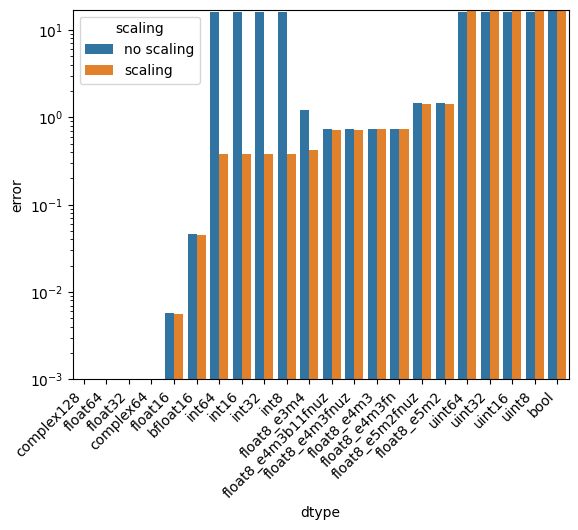

In [106]:

import seaborn as sns
import pandas as pd
ordering = sorted(set(errors.keys()) & set(scaled_errors.keys()), key=lambda x: scaled_errors[x])
records = [(k, errors[k], 'no scaling') for k in ordering] + [(k, scaled_errors[k], 'scaling') for k in ordering]
df = pd.DataFrame.from_records(records, columns=['dtype', 'error', 'scaling'])
# plot error and scaled error side by side
plot = sns.barplot(data=df, x='dtype', y='error', hue='scaling', )
plot.set_yscale('log')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha='right');
plot.set_ylim(1e-3, 17)

Base error: 1.61e+01, min error: 9.87e-01
Base error: 5.77e-03, min error: 5.82e-03
Base error: 4.63e-06, min error: 9.94e-06
Base error: 4.06e-07, min error: 9.25e-06


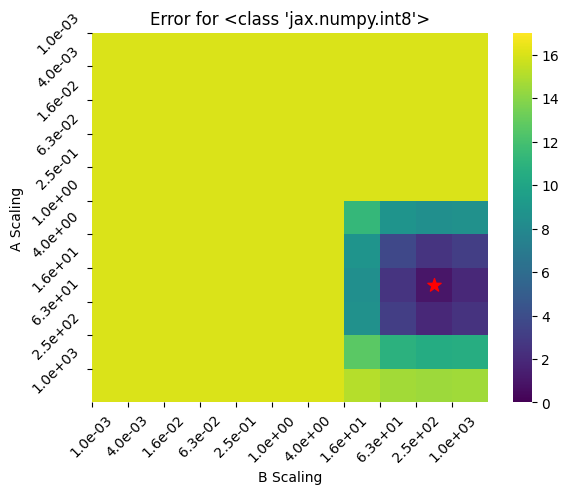

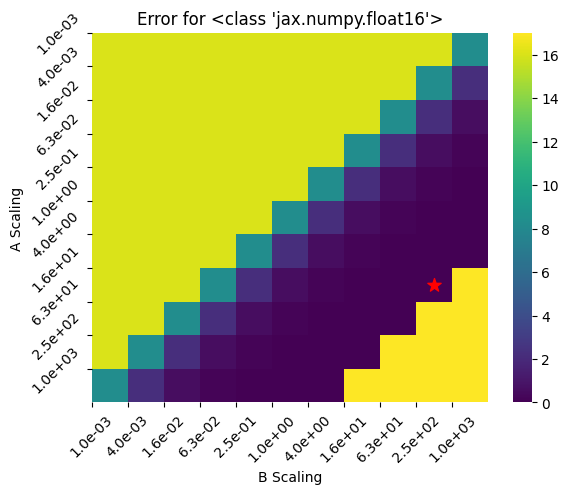

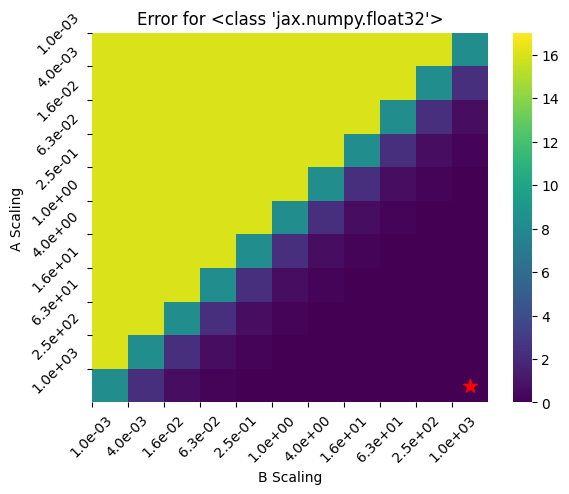

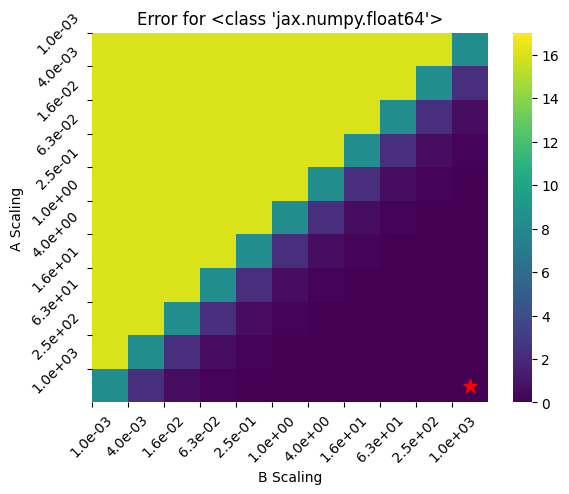

In [121]:
A_scaling = 10 ** jnp.linspace(-3, 3, 11)
B_scaling = 10 ** jnp.linspace(-3, 3, 11)

gt = (X.astype(jnp.float64) @ w.astype(jnp.float64)).astype(jnp.float32)

for dtype in [jnp.int8, jnp.float16, jnp.float32, jnp.float64]:
    errors = np.zeros((len(A_scaling), len(B_scaling)))
    cossims = np.zeros((len(A_scaling), len(B_scaling)))
    for i in range(len(A_scaling)):
        for j in range(len(B_scaling)):
            Xi = X * A_scaling[i]
            wj = w * B_scaling[j]
            pred = new_quantized_dot(Xi, wj, dtype) / (A_scaling[i] * B_scaling[j])
            error = jnp.linalg.norm(pred - gt, axis=-1).mean()
            errors[i, j] = error
            cossim_ = cossim(pred, gt, axis=-1).mean()
            cossims[i, j] = cossim_

    base_error = naive_quantized_dot(X, w, dtype)
    base_error = jnp.linalg.norm(base_error - gt, axis=-1).mean()
    print(f"Base error: {base_error:.2e}, min error: {errors.min():.2e}")

    plt.figure()
    plt.title(f"Error for {dtype}")
    sns.heatmap(errors, cmap='viridis', vmin=0, vmax=17) # print text of each cell
    argmin = np.unravel_index(errors.argmin(), errors.shape)
    plt.scatter(argmin[1] + 0.5, argmin[0] + 0.5, marker='*', color='red', s=100)
    plt.xlabel('B Scaling')
    plt.ylabel('A Scaling')
    plt.xticks(range(len(B_scaling)), [f"{x:.1e}" for x in B_scaling], rotation=45)
    plt.yticks(range(len(A_scaling)), [f"{x:.1e}" for x in A_scaling], rotation=45)
